In [9]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Modules for fast matrix multiplication
import scipy.sparse as sp
from sparse_dot_mkl import dot_product_mkl

In [5]:
def remove_isolated_vertices(adj_matrix):
    """
    Removes isolated vertices from the adjacency matrix.

    Args:
        adj_matrix (np.array): Adjacency matrix of the graph.

    Returns:
        new_matrix (np.array): Adjacency matrix without isolated vertices.
        non_isolated_indices (np.array): Indices of vertices that are not isolated.
    """
    # Compute the degree of each vertex (row sum)
    vertex_degrees = adj_matrix.sum(axis=1)

    # Find indices of non-isolated vertices (degree ≠ 0)
    non_isolated_indices = np.where(vertex_degrees != 0)[0]

    # Build new adjacency matrix with only non-isolated vertices
    new_matrix = adj_matrix[np.ix_(non_isolated_indices, non_isolated_indices)]

    return new_matrix, non_isolated_indices


def ksi_centrality(adj_matrix, ksi_regime='normalized', matrix_regime='numpy'):
    """
    Computes the ksi-centrality vector for each vertex in the graph.

    The graph is assumed to be undirected and optionally weighted.

    Algorithm:
        1. Create a binary indicator matrix B where B[i, j] = 1 if A[i, j] > 0, else 0.
        2. Compute second-degree weights: second_weight = B @ A,
           where second_weight[i, j] aggregates edge weights leading to j via neighbors of i.
        3. Zero out elements corresponding to direct neighbors (A[i, j] > 0) and the diagonal (i == j).
        4. Normalize each row by the sum of outgoing edge weights (weighted degree).

    Args:
        adj_matrix (np.array): Symmetric adjacency matrix of a connected graph.
        ksi_regime (str): Either "normalized" (default) or "regular".
        matrix_regime (str): Either "numpy" for dense arrays or "scipy_sparce" for sparse matrix operations.

    Returns:
        ksi_vector (np.array): Computed ksi-centrality values.
    """
    if matrix_regime == 'numpy':
        # 1. Binarize the adjacency matrix: edge presence as 1
        B = (adj_matrix > 0).astype(int)

        # 2. Compute second-degree weights
        second_weight = B @ adj_matrix

    elif matrix_regime == 'scipy_sparce':
        A_sparse = sp.csr_matrix(adj_matrix)

        # Binarize: B[i, j] = 1 if A[i, j] > 0
        B_sparse = A_sparse.copy()
        B_sparse.data[:] = 1

        # Perform sparse matrix multiplication
        second_weight_sparse = dot_product_mkl(B_sparse, A_sparse)

        # Convert to dense array for further processing
        second_weight = second_weight_sparse.toarray()

    else:
        raise ValueError("matrix_regime must be 'numpy' or 'scipy_sparce'")

    # 3. Exclude direct neighbors and self-loops
    exclusion_mask = (adj_matrix > 0) | np.eye(adj_matrix.shape[0], dtype=bool)
    second_weight[exclusion_mask] = 0

    # 4. Normalize by weighted degree (row sum)
    weighted_deg = adj_matrix.sum(axis=1)

    if ksi_regime == "regular":
        normalized_second = second_weight / weighted_deg[:, np.newaxis]
        ksi_vector = normalized_second.sum(axis=1)

    elif ksi_regime == "normalized":
        # Count number of neighbors
        neighbor_count = B.sum(axis=1)

        # First normalize by weighted degree
        temp = second_weight / weighted_deg[:, np.newaxis]

        # Further normalize by number of non-neighbors
        normalized_second = temp / (len(adj_matrix) - neighbor_count[:, np.newaxis])
        ksi_vector = normalized_second.sum(axis=1)

    else:
        raise ValueError("Unknown ksi_regime. Use 'regular' or 'normalized'.")

    return ksi_vector


In [ ]:
# Example: Generate a scale-free network using the Barabási–Albert model
G = nx.barabasi_albert_graph(10000, 3)

# Convert the graph to an adjacency matrix (NumPy array)
A = nx.to_numpy_array(G)

# Remove isolated vertices, if any (though BA model typically doesn't produce them)
A = remove_isolated_vertices(A)[0]

In [27]:
# Compute ksi-centrality using sparse matrices (faster if the matrix is truly sparse)
# In our case, the Barabási–Albert (BA) graph is indeed sparse: each node connects to only a few others,
# so the adjacency matrix contains mostly zeros.
ksi = ksi_centrality(A, ksi_regime='regular', matrix_regime='scipy_sparce')

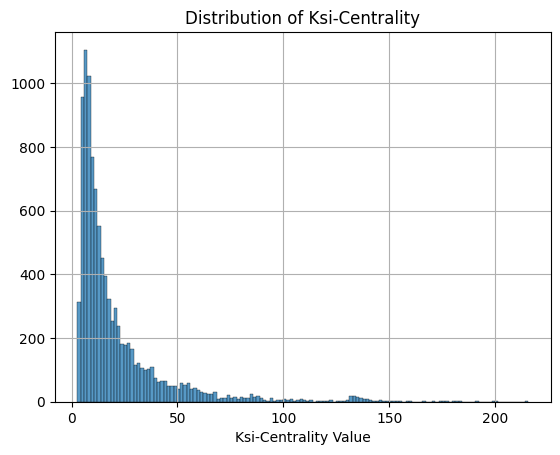

In [ ]:
# Distribution of ksi-centrality for a synthetic Barabási–Albert graph
sns.histplot(ksi)
plt.title("Distribution of Ksi-Centrality")
plt.xlabel("Ksi-Centrality Value")
plt.ylabel('')
plt.grid(True)
plt.show()

In [ ]:
#real network example - https://networks.skewed.de/net/facebook_organizations S1

real_edges = pd.read_csv('facebook_s1.csv')
real_g = nx.to_numpy_array(nx.from_pandas_edgelist(real_edges))

In [32]:
len(real_edges)

2369

In [28]:
real_ksi = ksi_centrality(real_g, ksi_regime= 'regular', matrix_regime = 'scipy_sparce')

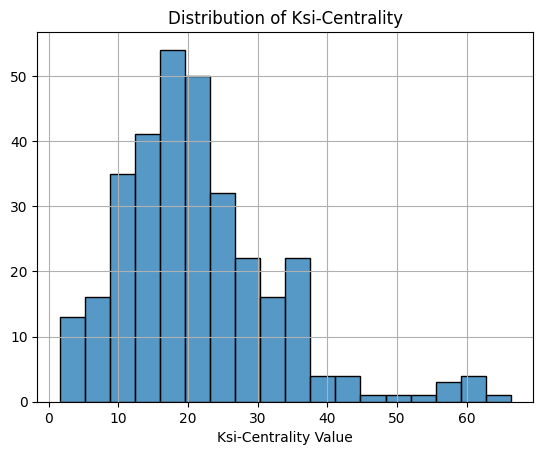

In [16]:
#Distribution of ksi-centrality for a real network
sns.histplot(real_ksi)
plt.title("Distribution of Ksi-Centrality")
plt.xlabel("Ksi-Centrality Value")
plt.ylabel('')
plt.grid(True)
plt.show()

# Scipy sparce realization

In [25]:
def remove_isolated_vertices_sparse(A_sparse):
    """
    Removes isolated vertices from a sparse adjacency matrix.

    Args:
        A_sparse (scipy.sparse matrix): Sparse adjacency matrix.

    Returns:
        new_A_sparse (scipy.sparse matrix): Adjacency matrix without isolated vertices.
        non_isolated_indices (np.ndarray): Indices of non-isolated vertices.
    """
    # Compute degree of each vertex (row sum)
    degrees = np.array(A_sparse.sum(axis=1)).ravel()

    # Find indices of non-isolated vertices
    non_isolated_indices = np.where(degrees != 0)[0]

    # Extract submatrix (first rows, then columns)
    new_A_sparse = A_sparse[non_isolated_indices, :][:, non_isolated_indices]

    return new_A_sparse, non_isolated_indices


def ksi_centrality_sparse(A_sparse, ksi_regime='normalized'):
    """
    Computes the ksi-centrality vector using only sparse matrix operations. (instead of numpy  multiplication in ksi_centrality)

    Algorithm:
        1. Binarize A_sparse: create B_sparse where all non-zero elements are set to 1.
        2. Compute second-degree weights: second_weight = B_sparse @ A_sparse.
        3. Remove contributions from direct neighbors and self-loops by masking.
        4. Normalize each row by the weighted degree.
           If ksi_regime is 'normalized', apply an additional normalization by (n - number of neighbors).

    Args:
        A_sparse (scipy.sparse matrix): Symmetric sparse adjacency matrix (CSR format recommended).
        ksi_regime (str): Either 'regular' or 'normalized'.

    Returns:
        second_weight_sparse (scipy.sparse matrix): Matrix of second-degree weights after exclusion.
        ksi_vector (np.ndarray): Computed ksi-centrality values.
    """
    A_sparse = A_sparse.tocsr()

    # 1. Binarize weighted graph
    B_sparse = A_sparse.copy()
    B_sparse.data = np.ones_like(B_sparse.data)

    # 2. Compute second-degree weights
    second_weight_sparse = B_sparse @ A_sparse

    # 3. Mask direct neighbors and diagonal
    A_binary = A_sparse.copy()
    A_binary.data = np.ones_like(A_binary.data)

    mask = A_binary + sp.eye(A_sparse.shape[0], format='csr')
    second_weight_sparse = second_weight_sparse - second_weight_sparse.multiply(mask)

    # 4. Normalize each row by weighted degree
    weighted_deg = np.array(A_sparse.sum(axis=1)).ravel()
    D_inv = sp.diags(1 / weighted_deg)
    normalized_second_sparse = D_inv @ second_weight_sparse

    if ksi_regime == 'regular':
        # Sum each row to get ksi-centrality vector
        ksi_vector = np.array(normalized_second_sparse.sum(axis=1)).ravel()

    elif ksi_regime == 'normalized':
        # Compute number of neighbors per vertex
        neighbor_count = np.array(A_binary.sum(axis=1)).ravel()
        n = A_sparse.shape[0]

        # Additional normalization by (n - number of neighbors)
        norm_factor = n - neighbor_count
        N_inv = sp.diags(1 / norm_factor)

        normalized_second_sparse = N_inv @ normalized_second_sparse
        ksi_vector = np.array(normalized_second_sparse.sum(axis=1)).ravel()

    else:
        raise ValueError("Unknown ksi_regime. Use 'regular' or 'normalized'.")

    return ksi_vector


In [19]:
A_sparse = nx.to_scipy_sparse_array(G, format='csr')

In [24]:
A_sparse, _ = remove_isolated_vertices_sparse(A_sparse)

In [26]:
ksi_vector_sparce = ksi_centrality_sparse(A_sparse, ksi_regime='regular')